This notebook contains a summary of how one can use Seaborn to perform data visualization, based on examples collected from https://seaborn.pydata.org.  I consider data visualization methods for performing univariate, bivariate and multivariate analysis, for (combinations of) categorical and continuous variables.

First, load some basic libraries.

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic
import warnings
warnings.filterwarnings("ignore")

Mosaic plot can be used for visualizing relationship among two or more categorical variables, based on conditional probabilities.  It can be viewed as a graphical way of representing information summarized in pd.crosstab().

In [2]:
# https://stackoverflow.com/questions/45352585/how-to-make-a-mosaic-plot-in-matplotlib
def mosaic_plot(df, dic_color_row, row_labels=None, col_labels=None, alpha_label=None, top_label="Size",
                x_label=None, y_label=None, pad=0.01, color_ylabel=False, ax=None, order="Size"):
    """ 

    From a contingency table NxM, plot a mosaic plot with the values inside. There should be a double-index for rows
    e.g.
                                         3   4   1   0   2  5
        Index_1          Index_2                       
        AA               C               0   0   0   2   3  0
                         P               6   0   0  13   0  0
        BB               C               0   2   0   0   0  0
                         P              45   1  10  10   1  0
        CC               C               0   6  35  15  29  0
                         P               1   1   0   2   0  0
        DD               C               0  56   0   3   0  0
                         P              30   4   2   0   1  9

    order: how columns are order, by default, from the biggest to the smallest in term of category. Possible values are 
        - "Size" [default]
        - "Normal": as the columns are order in the input df
        - list of column names to reorder the column
    top_label: Size of each columns. The label can be changed to adapt to your value. 
               If False, nothing is displayed and the secondary legend is set on top instead of on right.  
    """

    is_multi = len(df.index.names) == 2
    if ax == None:
        fig, ax = plt.subplots(1,1, figsize=(len(df.columns), len(df.index.get_level_values(0).unique())))

    size_col = df.sum().sort_values(ascending=False)
    prop_com = size_col.div(size_col.sum())

    if order == "Size":
        df = df[size_col.index.values]
    elif order == "Normal":
        prop_com = prop_com[df.columns]
        size_col = size_col[df.columns]
    else:
        df = df[order]
        prop_com = prop_com[order]
        size_col = size_col[order]

    if is_multi:
        inner_index = df.index.get_level_values(1).unique()
        prop_ii0 = (df.swaplevel().loc[inner_index[0]]/(df.swaplevel().loc[inner_index[0]]+df.swaplevel().loc[inner_index[1]])).fillna(0)
        alpha_ii = 0.5
        true_y_labels = df.index.levels[0]
    else:
        alpha_ii = 1
        true_y_labels = df.index

    Yt = (df.groupby(level=0).sum().iloc[:,0].div(df.groupby(level=0).sum().iloc[:,0].sum())+pad).cumsum() - pad
    Ytt = df.groupby(level=0).sum().iloc[:,0].div(df.groupby(level=0).sum().iloc[:,0].sum())

    x = 0    
    for j in df.groupby(level=0).sum().iteritems():
        bot = 0
        S = float(j[1].sum())
        for lab, k in j[1].iteritems():
            bars = []
            ax.bar(x, k/S, width=prop_com[j[0]], bottom=bot, color=dic_color_row[lab], alpha=alpha_ii, lw=0, align="edge")
            if is_multi:
                ax.bar(x, k/S, width=prop_com[j[0]]*prop_ii0.loc[lab, j[0]], bottom=bot, color=dic_color_row[lab], lw=0, alpha=1, align="edge")
            bot += k/S + pad
        x += prop_com[j[0]] + pad

    ## Aesthetic of the plot and ticks
    # Y-axis
    if row_labels == None:
        row_labels = Yt.index
    ax.set_yticks(Yt - Ytt/2)
    ax.set_yticklabels(row_labels)

    ax.set_ylim(0, 1 + (len(j[1]) - 1) * pad)
    if y_label == None:
        y_label = df.index.names[0]
    ax.set_ylabel(y_label)

    # X-axis
    if col_labels == None:
        col_labels = prop_com.index
    xticks = (prop_com + pad).cumsum() - pad - prop_com/2.
    ax.set_xticks(xticks)
    ax.set_xticklabels(col_labels)
    ax.set_xlim(0, prop_com.sum() + pad * (len(prop_com)-1))

    if x_label == None:
        x_label = df.columns.name
    ax.set_xlabel(x_label)

    # Top label
    if top_label:
        ax2 = ax.twiny()
        ax2.set_xlim(*ax.get_xlim())
        ax2.set_xticks(xticks) 
        ax2.set_xticklabels(size_col.values.astype(int))
        ax2.set_xlabel(top_label)
        ax2.tick_params(top=False, right=False, pad=0, length=0)

    # Ticks and axis settings

    ax.tick_params(top=False, right=False, pad=5)
    sns.despine(left=0, bottom=False, right=0, top=0, offset=3)

    # Legend
    if is_multi: 
        if alpha_label == None:
            alpha_label = inner_index
        bars = [ax.bar(np.nan, np.nan, color="0.2", alpha=[1, 0.5][b]) for b in range(2)]
        if top_label:
            plt.legend(bars, alpha_label, loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, )
        else:
            plt.legend(bars, alpha_label, loc="lower center", bbox_to_anchor=(0.5, 1), ncol=2)
    plt.tight_layout(rect=[0, 0, .9, 0.95])
    if color_ylabel:
        for tick, label in zip(ax.get_yticklabels(), true_y_labels):
            tick.set_bbox(dict( pad=5, facecolor=dic_color_row[label]))
            tick.set_color("w")
            tick.set_fontweight("bold")

    return ax

# Datasets for Visualization

We will use the following datasets for different visualization methods.

In [3]:
GLOBAL_PATH = './'
data_dir = os.path.join(GLOBAL_PATH, 'StudentsPerformance.csv')
data = pd.read_csv(data_dir)
data.rename(columns=({'gender':'Gender', 
                      'race/ethnicity':'Race/Ethnicity',
                      'parental level of education':'Parental_Level_of_Education',
                      'lunch':'Lunch', 
                      'test preparation course':'Test_Preparation_Course',
                      'math score':'Math_Score',
                      'reading score':'Reading_Score',
                      'writing score':'Writing_Score'}), inplace=True)
data.head()

,Gender,Race/Ethnicity,Parental_Level_of_Education,Lunch,Test_Preparation_Course,Math_Score,Reading_Score,Writing_Score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [4]:
tips = sns.load_dataset("tips")
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [5]:
fmri = sns.load_dataset("fmri")
fmri.head()

,subject,timepoint,event,region,signal
0,s13,18,stim,parietal,-0.017552
1,s5,14,stim,parietal,-0.080883
2,s12,18,stim,parietal,-0.081033
3,s11,18,stim,parietal,-0.046134
4,s10,18,stim,parietal,-0.037970


In [6]:
flights = sns.load_dataset("flights")
flights.head()

,year,month,passengers
0,1949,January,112
1,1949,February,118
2,1949,March,132
3,1949,April,129
4,1949,May,121


# Univariate Analysis

### Continuous variable.

To visualize the distribution of a continuous variable, we can use histogram, kernel density plot, box plot, strip plot, violin plot, or swarm plot.

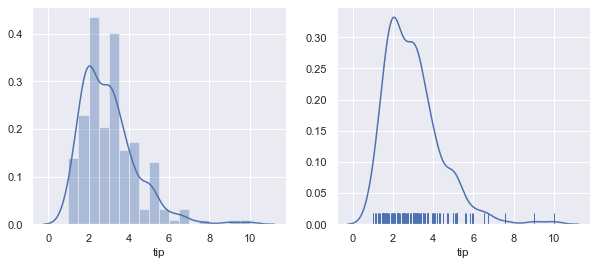

In [7]:
sns.set(style='darkgrid')
fig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.distplot(tips['tip'])
plt.subplot(1,2,2)
sns.distplot(tips['tip'], rug=True, hist=False)

Text(0, 0.5, 'Frequency')

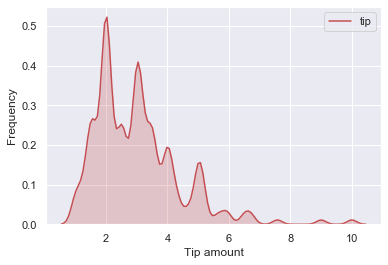

In [8]:
sns.kdeplot(tips['tip'],shade=True, color='r', bw=.15)
plt.xlabel('Tip amount')
plt.ylabel('Frequency')

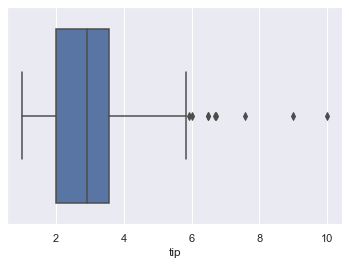

In [9]:
sns.boxplot(tips['tip'])

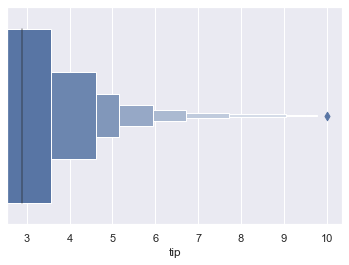

In [10]:
sns.boxenplot(tips['tip'])

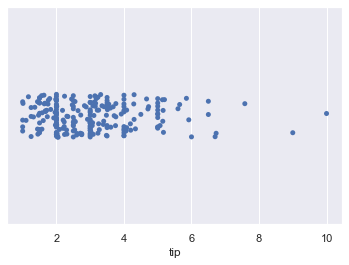

In [11]:
sns.stripplot(tips['tip'])

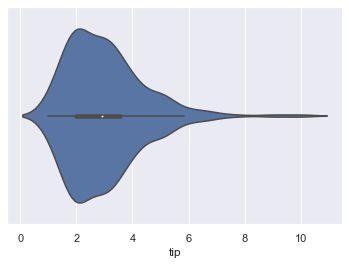

In [12]:
sns.violinplot(tips['tip'])

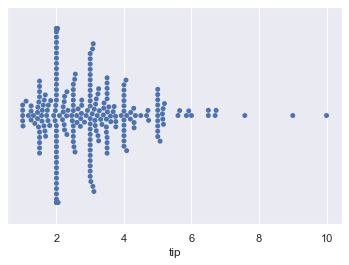

In [13]:
sns.swarmplot(tips['tip'])

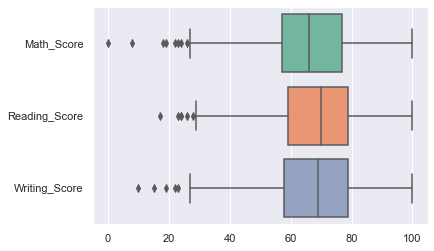

In [14]:
# Boxplots for all continuous variables.
sns.boxplot(data=data, orient="h", palette="Set2")

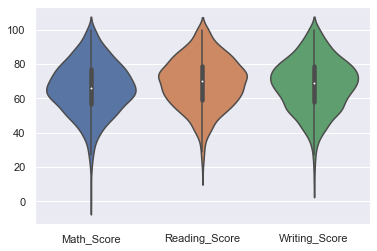

In [15]:
# Violin plots for all continuous variables.
sns.violinplot(data=data)

### Categorical variable.

To visualize the distribution of a categorical variable, we can consider count plot or pie chart.

##### Count plot

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

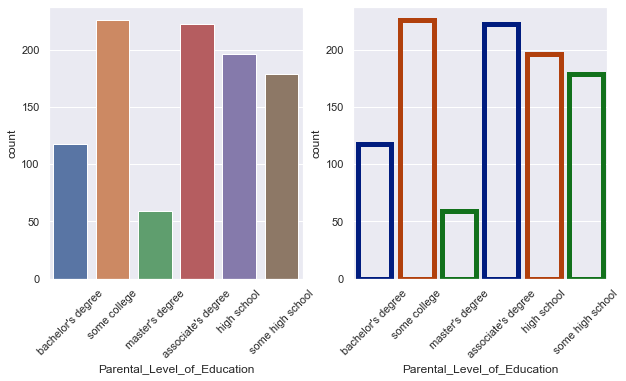

In [16]:
fig = plt.figure(figsize=(10,5))

plt.subplot(121)
sns.countplot(data["Parental_Level_of_Education"])
plt.xticks(rotation=45)

plt.subplot(122)
sns.countplot(x="Parental_Level_of_Education", data=data, facecolor=(0, 0, 0, 0),
              linewidth=5, edgecolor=sns.color_palette("dark", 3))
plt.xticks(rotation=45)

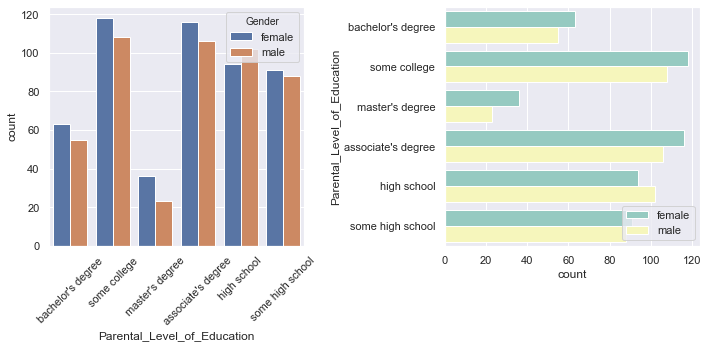

In [17]:
fig = plt.figure(figsize=(10,5))

plt.subplot(121)
sns.countplot(x="Parental_Level_of_Education", hue="Gender", data=data)
plt.xticks(rotation=45)

plt.subplot(122)
sns.countplot(y="Parental_Level_of_Education", hue="Gender", data=data, palette="Set3")
plt.legend(loc=4)
fig.tight_layout()

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

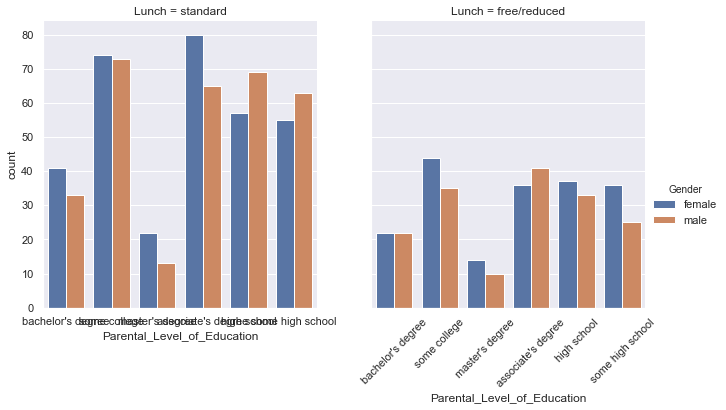

In [18]:
# Use catplot() to combine a countplot() and a FacetGrid. This allows grouping within additional categorical 
# variables. Using catplot() is safer than using FacetGrid directly, as it ensures synchronization of variable
# order across facets.
sns.catplot(x="Parental_Level_of_Education", hue="Gender", col="Lunch", data=data, 
            kind="count", height=5, aspect=0.9)
plt.xticks(rotation=45)

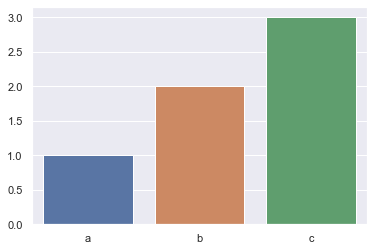

In [19]:
x = pd.Series({'a':1, 'b':2, 'c':3})
sns.barplot(x.index, x.values)

##### Pie chart

Text(0.5, 1.0, 'Race/Ethnicity According Analysis')

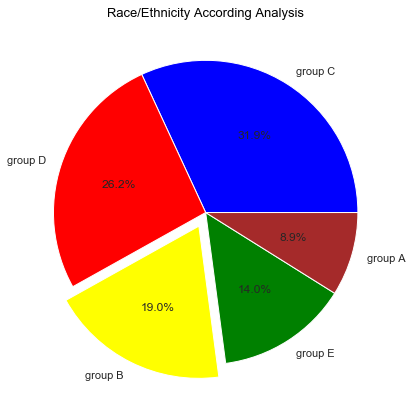

In [20]:
labels = data['Race/Ethnicity'].value_counts().index
values = data['Race/Ethnicity'].value_counts().values
colors = ['blue','red','yellow','green','brown']
explode = [0,0,0.1,0,0]

# Plot pie chart.
plt.figure(figsize=(7,7))
plt.pie(values, labels=labels, colors=colors, explode=explode, autopct='%1.1f%%')
plt.title('Race/Ethnicity According Analysis', color='black', fontsize=13)

# Bivariate or Multivariate Analysis

### Continuous variable VS Continuous variable.

To examine the relationship between two continuous variables, we can use scatter plot, line plot, lm plot, joint plot, density plot or pair plot.

##### Scatterplot

In [21]:
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


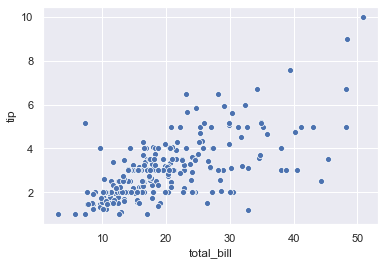

In [22]:
sns.scatterplot(x="total_bill", y="tip", data=tips)

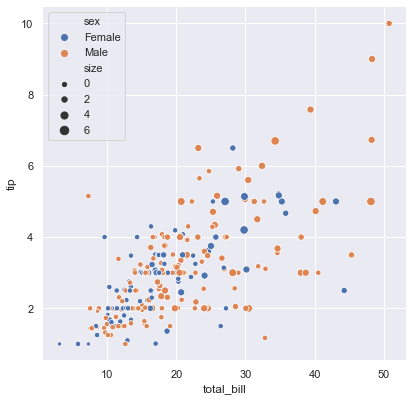

In [23]:
# We can represent additional information for the data points using color and sizing.
f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x="total_bill", y="tip", hue="sex", size="size", data=tips)

##### Line plot

Line plot is useful for time series or other ordered data.

In [24]:
fmri.head()

,subject,timepoint,event,region,signal
0,s13,18,stim,parietal,-0.017552
1,s5,14,stim,parietal,-0.080883
2,s12,18,stim,parietal,-0.081033
3,s11,18,stim,parietal,-0.046134
4,s10,18,stim,parietal,-0.037970


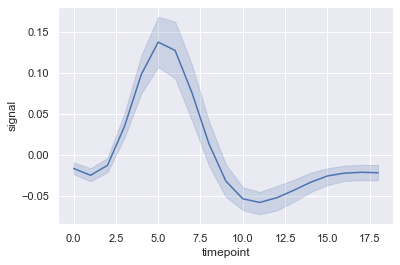

In [25]:
sns.lineplot(x="timepoint", y="signal", data=fmri)

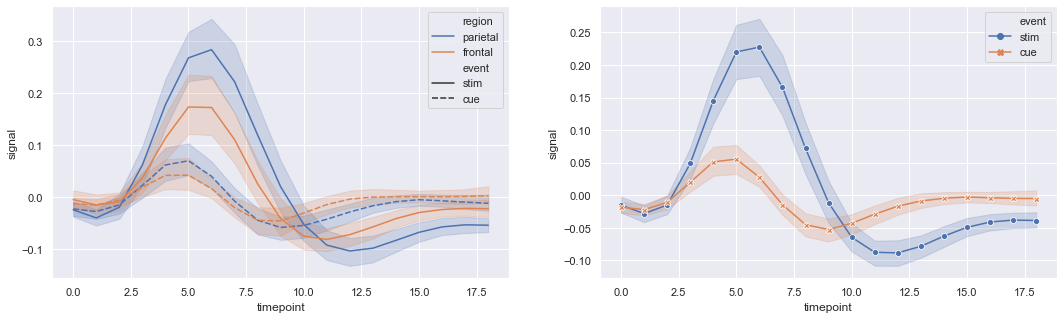

In [26]:
fig = plt.figure(figsize=(18,5))

plt.subplot(121)
sns.lineplot(x="timepoint", y="signal", hue="region", style="event", data=fmri)

plt.subplot(122)
sns.lineplot(x="timepoint", y="signal", hue="event", style="event", markers=True, dashes=False, data=fmri)

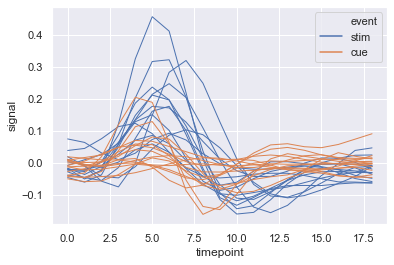

In [27]:
# Show experimental replicates instead of aggregating.
sns.lineplot(x="timepoint", y="signal", hue="event", units="subject", estimator=None, lw=1,
             data=fmri.query("region == 'frontal'"))

##### LM plot

LM plot is a scatterplot with least squares line and point wise confidence interval.

Text(0.5, 1, 'Tips VS Total Bill')

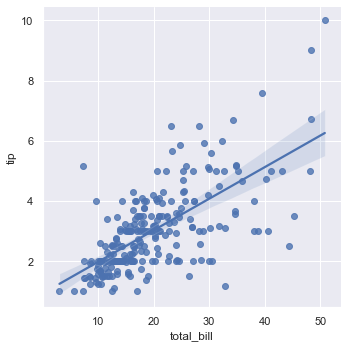

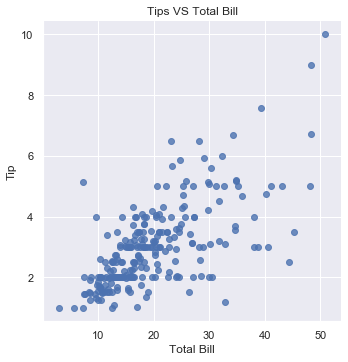

In [28]:
sns.lmplot(x="total_bill", y="tip", data=tips)
sns.lmplot(x="total_bill", y="tip", fit_reg=False, data=tips)
plt.xlabel('Total Bill')
plt.ylabel('Tip')
plt.title('Tips VS Total Bill')

Text(0.5, 1, 'Tips VS Total Bill')

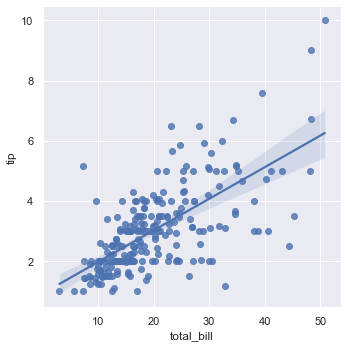

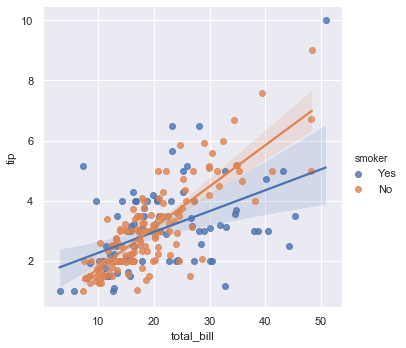

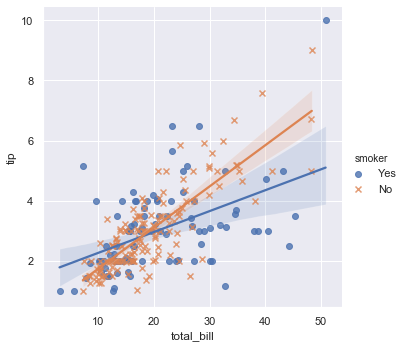

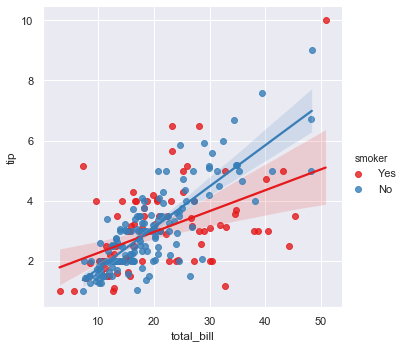

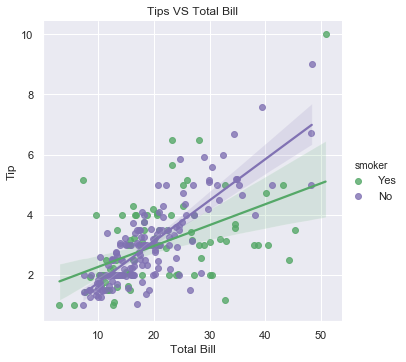

In [29]:
sns.lmplot(x="total_bill", y="tip", data=tips)
sns.lmplot(x="total_bill", y="tip", hue="smoker", data=tips)
sns.lmplot(x="total_bill", y="tip", hue="smoker", data=tips, markers=["o", "x"])
sns.lmplot(x="total_bill", y="tip", hue="smoker", data=tips, palette="Set1")
sns.lmplot(x="total_bill", y="tip", hue="smoker", data=tips, palette=dict(Yes="g", No="m"))
plt.xlabel('Total Bill')
plt.ylabel('Tip')
plt.title('Tips VS Total Bill')

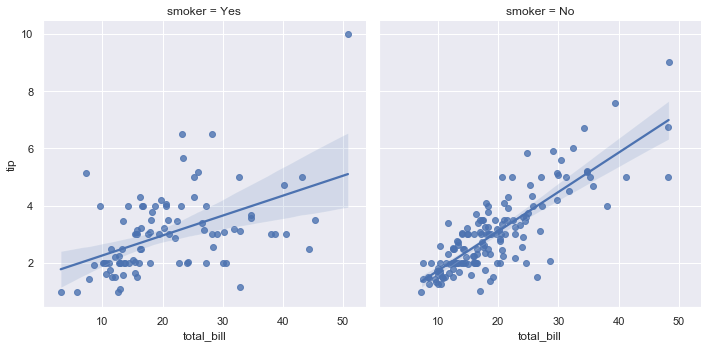

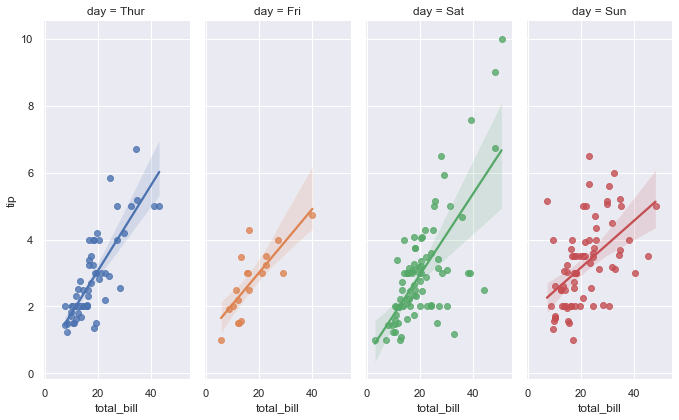

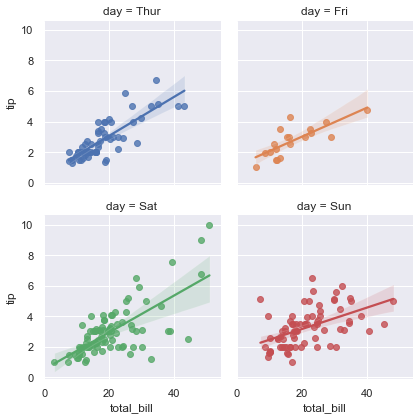

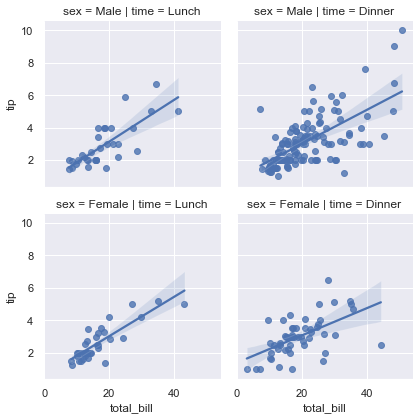

In [30]:
sns.lmplot(x="total_bill", y="tip", col="smoker", data=tips)

sns.lmplot(x="total_bill", y="tip", hue="day", col="day", data=tips, 
           height=6, aspect=.4, x_jitter=.1)

sns.lmplot(x="total_bill", y="tip", col="day", hue="day", data=tips, 
           col_wrap=2, height=3)

sns.lmplot(x="total_bill", y="tip", row="sex", col="time", data=tips, 
           height=3)

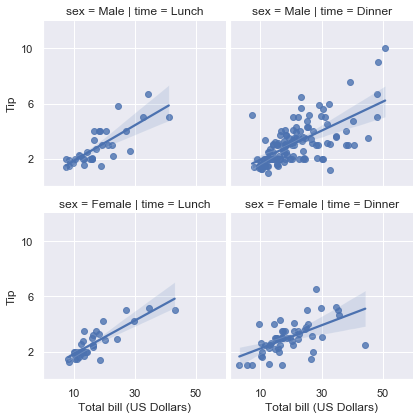

In [31]:
g = sns.lmplot(x="total_bill", y="tip", row="sex", col="time",
               data=tips, height=3)
g = (g.set_axis_labels("Total bill (US Dollars)", "Tip")
      .set(xlim=(0, 60), ylim=(0, 12), xticks=[10, 30, 50], yticks=[2, 6, 10])
      .fig.subplots_adjust(wspace=.02))

##### Joint plot

Jointplot plots both bivariate and univariate distributions.

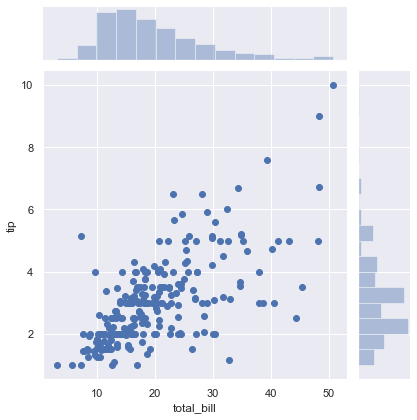

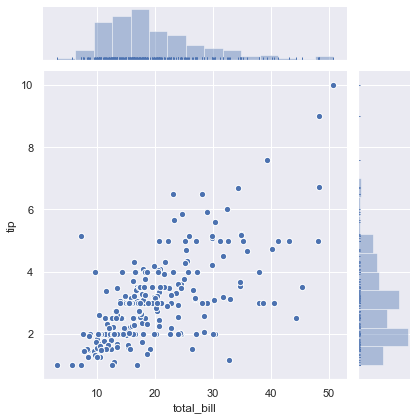

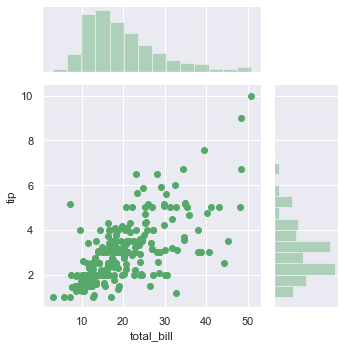

In [32]:
sns.jointplot(x="total_bill", y="tip", data=tips)
sns.jointplot(x="total_bill", y="tip", data=tips, marginal_kws=dict(bins=15, rug=True),
              annot_kws=dict(stat="r"), s=40, edgecolor="w", linewidth=1)
# Adjust ratio of joint axes height to marginal axes height
sns.jointplot(x="total_bill", y="tip", data=tips, height=5, ratio=3, color="g")

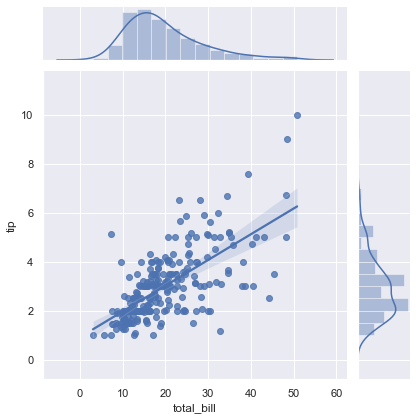

In [33]:
sns.jointplot("total_bill", "tip", data=tips, kind="reg")

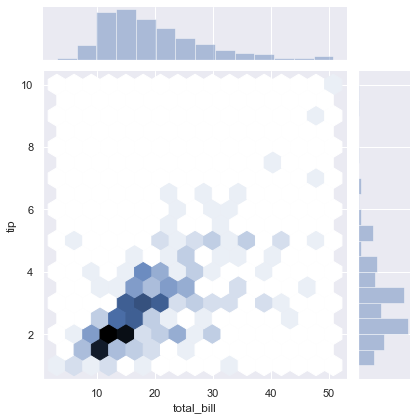

In [34]:
sns.jointplot("total_bill", "tip", data=tips, kind="hex")
# sns.jointplot("total_bill", "tip", data=tips, kind="hex").set_axis_labels("x", "y")

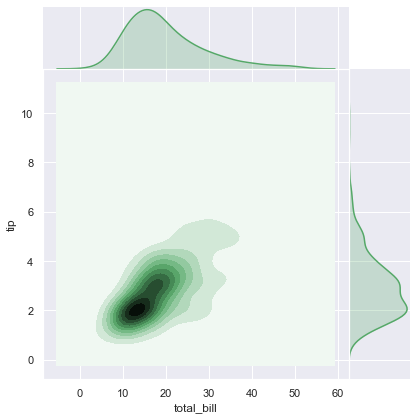

In [35]:
sns.jointplot("total_bill", "tip", data=tips, kind="kde", space=0, color="g")

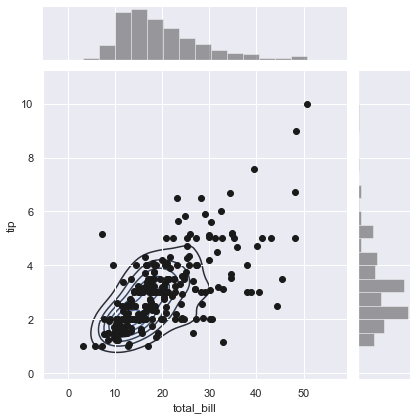

In [36]:
sns.jointplot("total_bill", "tip", data=tips, color="k").plot_joint(sns.kdeplot, zorder=0, n_levels=6)

##### Density plot

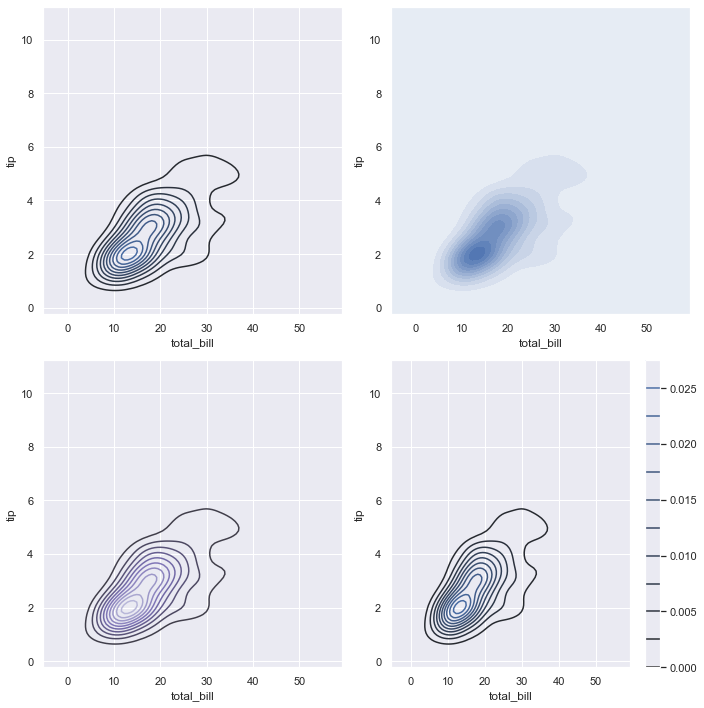

In [37]:
fig = plt.figure(figsize=(10,10))
sns.set_style('darkgrid')

plt.subplot(221)
sns.kdeplot(tips["total_bill"], tips["tip"])

plt.subplot(222)
sns.kdeplot(tips["total_bill"], tips["tip"], shade=True)

plt.subplot(223)
sns.kdeplot(tips["total_bill"], tips["tip"], nlevels=30, cmap="Purples_d")

plt.subplot(224)
sns.kdeplot(tips["total_bill"], tips["tip"], cbar=True) #add a colorbar for the contours

fig.tight_layout()

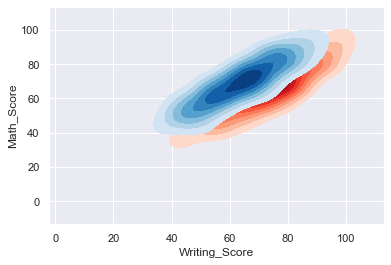

In [38]:
# Plot two shaded bivariate densities.
female = data[data['Gender']=='female']
male = data[data['Gender']=='male']
sns.kdeplot(female['Writing_Score'], female['Math_Score'],
            cmap="Reds", shade=True, shade_lowest=False)
sns.kdeplot(male['Writing_Score'], male['Math_Score'],
            cmap="Blues", shade=True, shade_lowest=False)

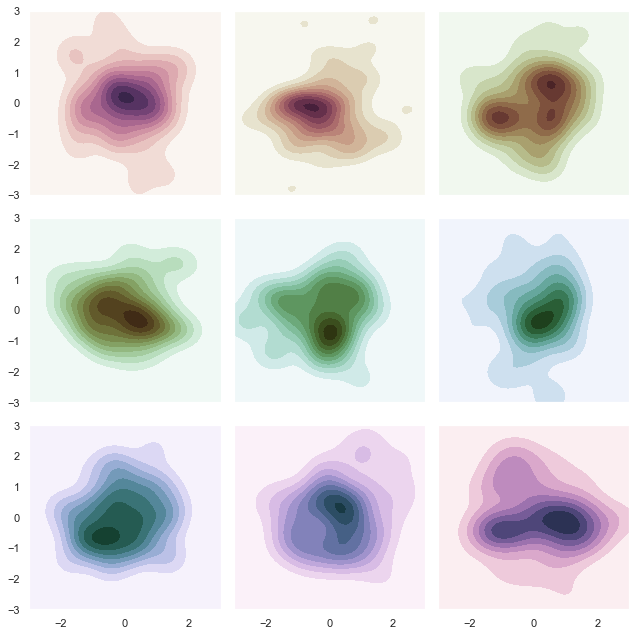

In [39]:
sns.set(style="dark")
rs = np.random.RandomState(50)

# Set up the matplotlib figure
f, axes = plt.subplots(3, 3, figsize=(9, 9), sharex=True, sharey=True)

# Rotate the starting point around the cubehelix hue circle
for ax, s in zip(axes.flat, np.linspace(0, 3, 10)):

    # Create a cubehelix colormap to use with kdeplot
    cmap = sns.cubehelix_palette(start=s, light=1, as_cmap=True)

    # Generate and plot a random bivariate dataset
    x, y = rs.randn(2, 50)
    sns.kdeplot(x, y, cmap=cmap, shade=True, cut=5, ax=ax)
    ax.set(xlim=(-3, 3), ylim=(-3, 3))

f.tight_layout()

##### Pairplot

Pairplot is useful for visualizing pairwise relationship among several variables.

In [40]:
data.head()

,Gender,Race/Ethnicity,Parental_Level_of_Education,Lunch,Test_Preparation_Course,Math_Score,Reading_Score,Writing_Score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


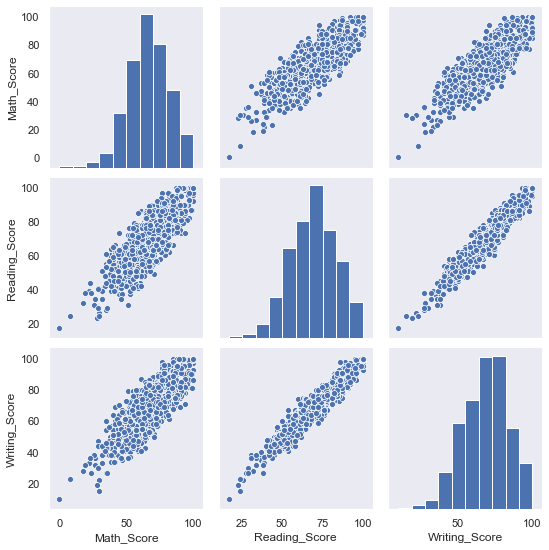

In [41]:
sns.pairplot(data)
# sns.pairplot(data, corner=True) #plot only the lower triangle of bivariate axes
# sns.pairplot(iris, diag_kind="kde") #use kernel density estimates for univariate plots
# sns.pairplot(iris, kind="reg") #fit linear regression models to the scatter plots
# sns.pairplot(data, vars=["Reading_Score", "Writing_Score"]) #height=3

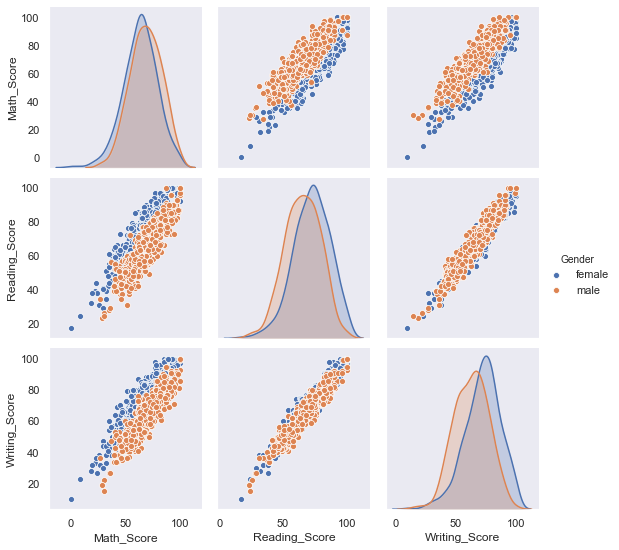

In [42]:
sns.pairplot(data, hue="Gender")

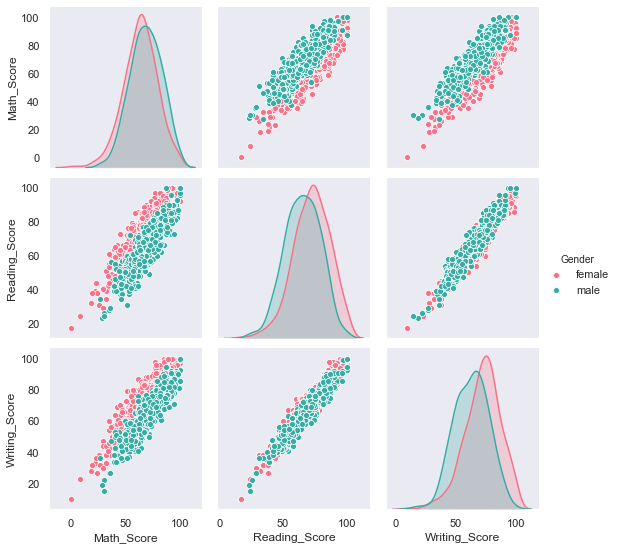

In [43]:
sns.pairplot(data, hue="Gender", palette="husl")

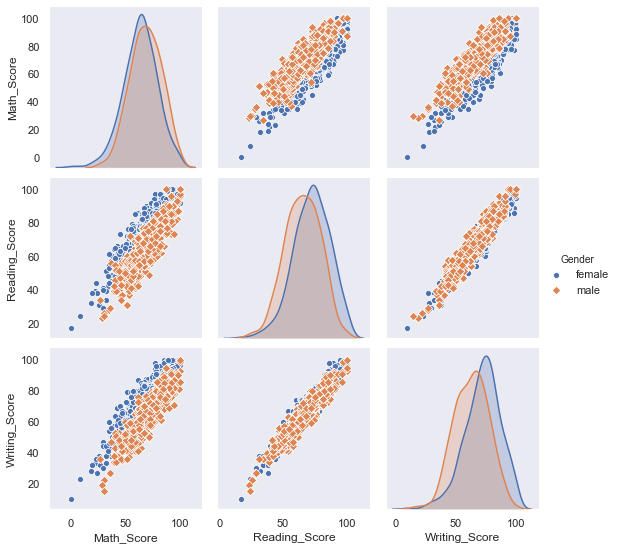

In [44]:
sns.pairplot(data, hue="Gender", markers=["o", "D"]) #o=circle, s=square, D=diamond

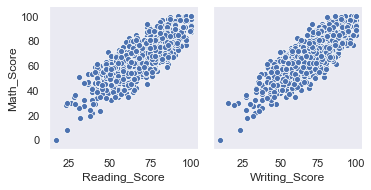

In [45]:
# Plot different variables in rows and columns.
sns.pairplot(data, x_vars=["Reading_Score", "Writing_Score"], y_vars=["Math_Score"])

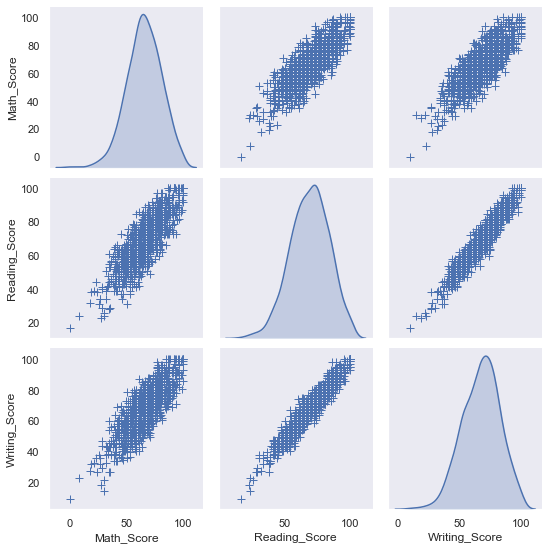

In [46]:
# Pass keyword arguments down to the underlying functions (it may be easier to use PairGrid directly.
sns.pairplot(data, diag_kind="kde", markers="+", 
             plot_kws=dict(s=50, edgecolor="b", linewidth=1),
             diag_kws=dict(shade=True))

### Continuous variable VS Categorical variable.

To visualize the conditional distribution of a continuous variable on a categorical variable, we can use box plot, strip plot, violin plot, swarm plot or bar plot.

##### Box plot

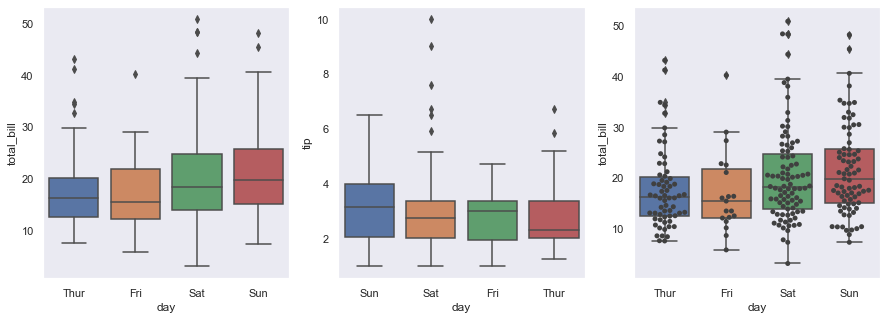

In [47]:
fig = plt.figure(figsize=(15,5))

plt.subplot(131)
sns.boxplot(x="day", y="total_bill", data=tips)

plt.subplot(132)
sns.boxplot(x="day", y="tip", data=tips, order=['Sun', 'Sat', 'Fri', 'Thur'])

plt.subplot(133)
sns.boxplot(x="day", y="total_bill", data=tips)
sns.swarmplot(x="day", y="total_bill", data=tips, color=".25")

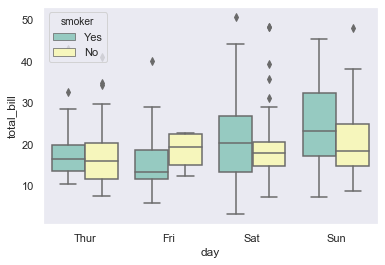

In [48]:
sns.boxplot(x="day", y="total_bill", hue="smoker", data=tips, palette="Set3")

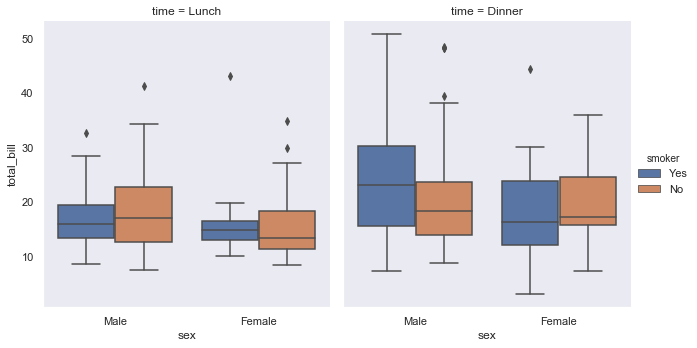

In [49]:
sns.catplot(x="sex", y="total_bill", hue="smoker", col="time", data=tips, 
            kind="box", height=5, aspect=.9)

##### Strip plot

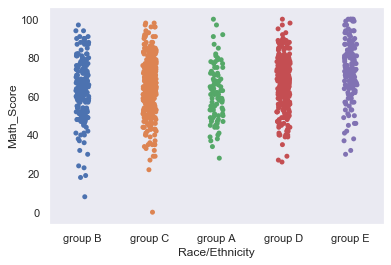

In [50]:
sns.stripplot(x='Race/Ethnicity', y='Math_Score', data=data)

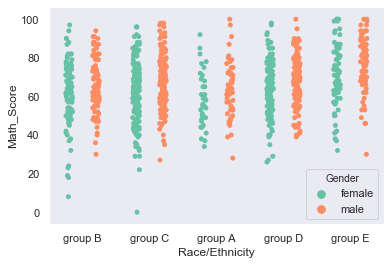

In [51]:
sns.stripplot(x='Race/Ethnicity', y='Math_Score', hue='Gender', data=data,
              jitter=True, dodge=True, palette="Set2")

##### Violin plot

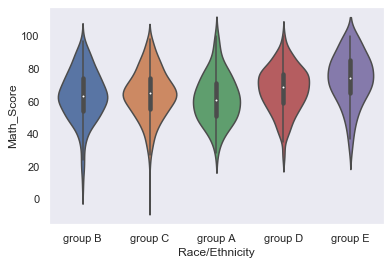

In [52]:
sns.violinplot(x='Race/Ethnicity', y='Math_Score', data=data)

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

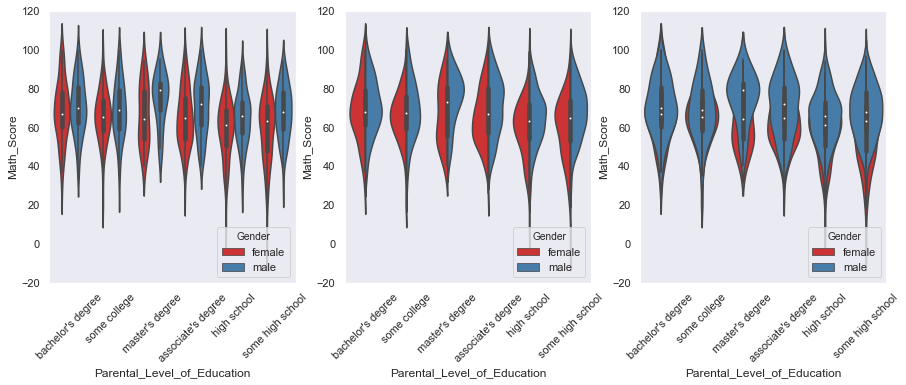

In [53]:
fig = plt.figure(figsize=(15,5))

plt.subplot(131)
sns.violinplot(x='Parental_Level_of_Education', y='Math_Score', hue='Gender', data=data, palette='Set1')
plt.xticks(rotation=45)

plt.subplot(132)
sns.violinplot(x='Parental_Level_of_Education', y='Math_Score', hue='Gender', data=data, palette='Set1', split=True)
plt.xticks(rotation=45)

plt.subplot(133)
sns.violinplot(x='Parental_Level_of_Education', y='Math_Score', hue='Gender', data=data, palette='Set1', dodge=False)
plt.xticks(rotation=45)

Text(0.5, 1.0, 'Math Score VS Parent Education Level')

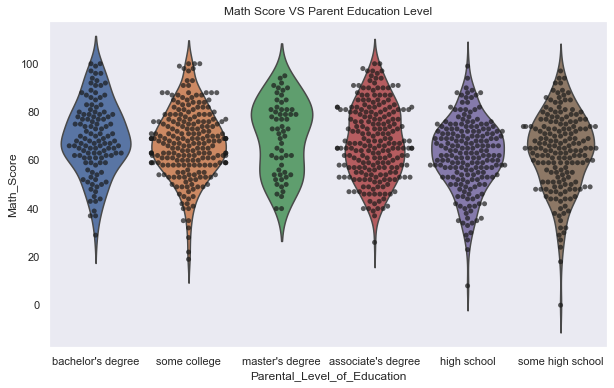

In [54]:
plt.figure(figsize=(10,6))
 
# Create plot
sns.violinplot(x='Parental_Level_of_Education', y='Math_Score', data=data, 
               inner=None) # Remove the bars inside the violins
 
sns.swarmplot(x='Parental_Level_of_Education', y='Math_Score', data=data, 
              color='k', # Make points black
              alpha=0.7) # and slightly transparent
 
# Set title with matplotlib
plt.title('Math Score VS Parent Education Level')

##### Swarm plot

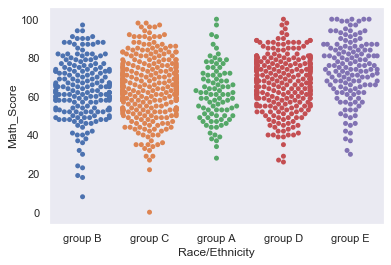

In [55]:
sns.swarmplot(x='Race/Ethnicity', y='Math_Score', data=data)

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

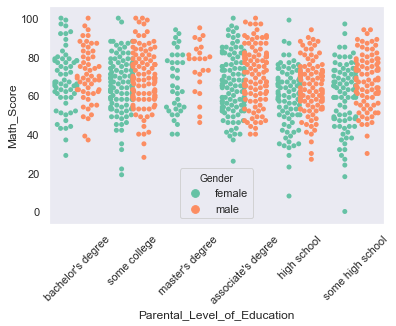

In [56]:
sns.swarmplot(x='Parental_Level_of_Education', y='Math_Score', hue='Gender', data=data,
              palette='Set2', dodge=True)
plt.xticks(rotation=45)

##### Bar plot

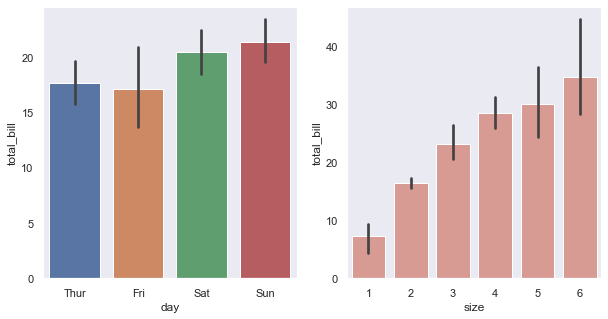

In [57]:
# Average total_bill for each day.
fig = plt.figure(figsize=(10,5))

plt.subplot(121)
sns.barplot(x="day", y="total_bill", data=tips)

plt.subplot(122)
sns.barplot(x="size", y="total_bill", data=tips, color="salmon", saturation=.5)

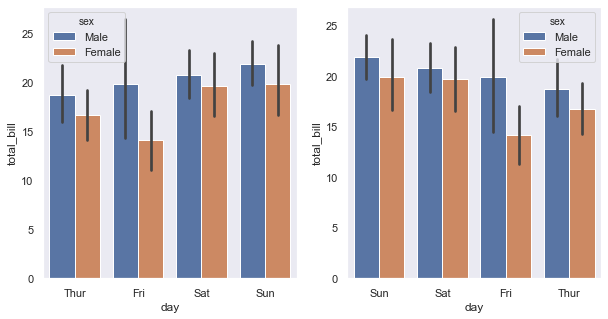

In [58]:
fig = plt.figure(figsize=(10,5))

plt.subplot(121)
sns.barplot(x="day", y="total_bill", hue = "sex", data=tips)

plt.subplot(122)
sns.barplot(x="day", y="total_bill", hue = "sex", data=tips, order=['Sun', 'Sat', 'Fri', 'Thur'])

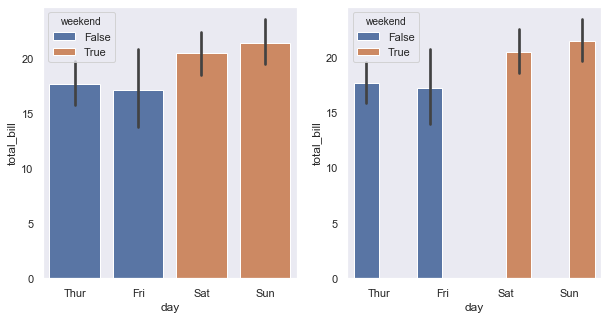

In [59]:
tips["weekend"] = tips["day"].isin(["Sat", "Sun"])

fig = plt.figure(figsize=(10,5))

plt.subplot(121)
sns.barplot(x="day", y="total_bill", hue="weekend", data=tips, dodge=False)

plt.subplot(122)
sns.barplot(x="day", y="total_bill", hue="weekend", data=tips, dodge=True)

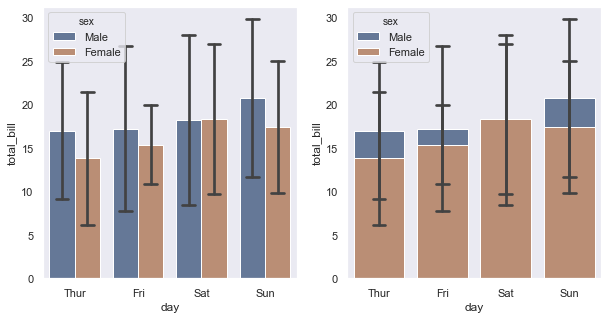

In [60]:
fig = plt.figure(figsize=(10,5))

plt.subplot(121)
sns.barplot(x="day", y="total_bill", hue='sex', data=tips, estimator=np.median, ci='sd', capsize=0.2, 
            saturation=0.5, dodge=True)

plt.subplot(122)
sns.barplot(x="day", y="total_bill", hue='sex', data=tips, estimator=np.median, ci='sd', capsize=0.2, 
            saturation=0.5, dodge=False)

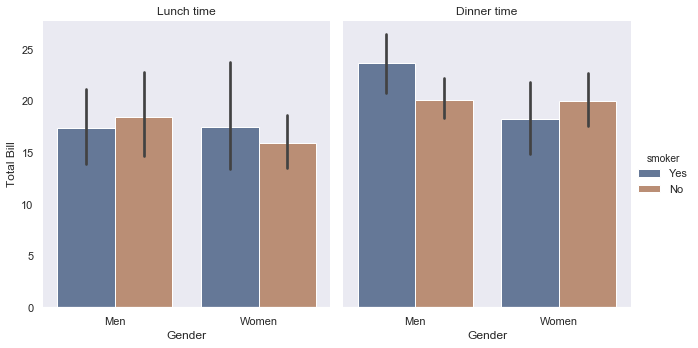

In [61]:
# Use catplot to show the relationship between a numerical and one or more categorical variables.
g = sns.catplot(x="sex", y="total_bill", hue="smoker", col="time", data=tips, 
            kind="bar", height=5, aspect=0.9, saturation=0.5)
(g.set_axis_labels("Gender", "Total Bill").set_xticklabels(["Men", "Women"])
 .set_titles("{col_name} {col_var}").despine(left=True))

##### Point plot

A point plot represents an estimate of central tendency for a numeric variable by the position of scatter plot points and provides some indication of the uncertainty around that estimate using error bars.  Point plots can be more useful than bar plots for focusing comparisons between different levels of one or more categorical variables. They are particularly adept at showing interactions: how the relationship between levels of one categorical variable changes across levels of a second categorical variable.

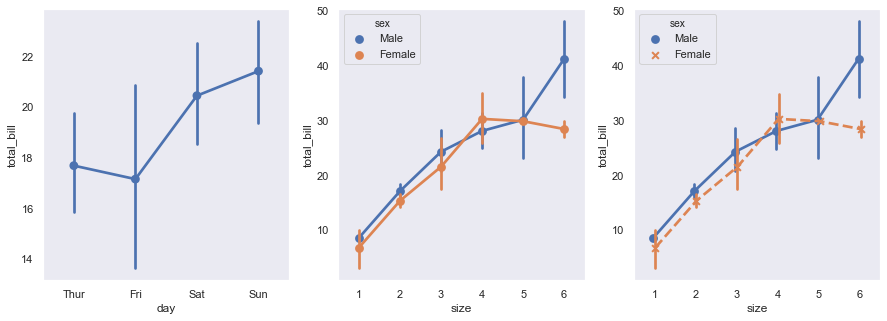

In [62]:
# Average total_bill for each day.
fig = plt.figure(figsize=(15,5))

plt.subplot(131)
sns.pointplot(x="day", y="total_bill", data=tips)

plt.subplot(132)
sns.pointplot("size", y="total_bill", hue="sex", data=tips)

plt.subplot(133)
sns.pointplot("size", y="total_bill", hue="sex", data=tips, dodge=True, markers=["o", "x"], linestyles=["-", "--"])

### Categorical variable VS Categorical variable.

To visualize relationship among several categorical variables, we can use divided bar plot, side-by-side bar plot, and mosaic plot.

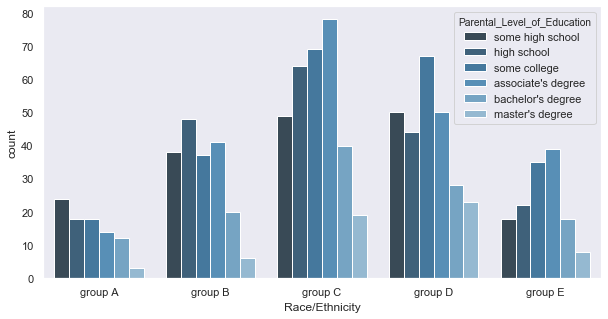

In [63]:
plt.figure(figsize=(10,5))
sns.countplot(x="Race/Ethnicity", hue="Parental_Level_of_Education", 
              order=["group A", "group B", "group C", "group D", "group E"], 
              hue_order = ["some high school", "high school", "some college", "associate's degree", "bachelor's degree", "master's degree"],
              data=data, palette="Blues_d")

(<Figure size 432x288 with 3 Axes>,
 OrderedDict([(('group B', "bachelor's degree"),
               (0.0, 0.0, 0.18627450980392157, 0.10353753235547886)),
              (('group B', 'some college'),
               (0.0,
                0.10681622088006902,
                0.18627450980392157,
                0.1915444348576359)),
              (('group B', "master's degree"),
               (0.0,
                0.30163934426229505,
                0.18627450980392157,
                0.031061259706643647)),
              (('group B', "associate's degree"),
               (0.0,
                0.3359792924935289,
                0.18627450980392157,
                0.21225194132873174)),
              (('group B', 'high school'),
               (0.0,
                0.5515099223468508,
                0.18627450980392157,
                0.2484900776531493)),
              (('group B', 'some high school'),
               (0.0,
                0.8032786885245903,
                0.18627

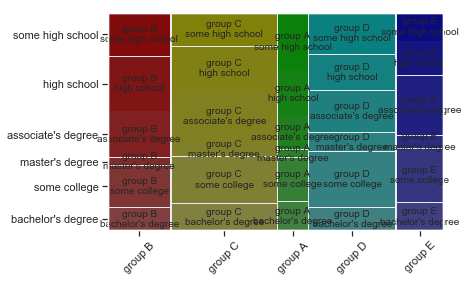

In [64]:
mosaic(data, ["Race/Ethnicity", "Parental_Level_of_Education"], label_rotation=[45, 0], labelizer=None)

In [65]:
d = pd.crosstab(data["Race/Ethnicity"], data["Parental_Level_of_Education"])
d

Parental_Level_of_Education,associate's degree,bachelor's degree,high school,master's degree,some college,some high school
Race/Ethnicity,,,,,,
group A,14,12,18,3,18,24
group B,41,20,48,6,37,38
group C,78,40,64,19,69,49
group D,50,28,44,23,67,50
group E,39,18,22,8,35,18


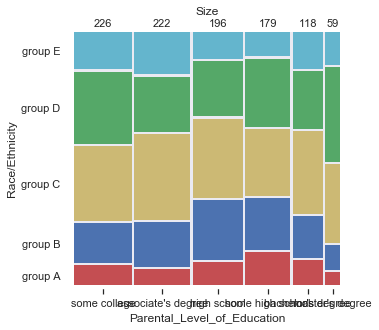

In [66]:
mosaic_plot(d, {"group A":"r", "group B":"b", "group C":"y", "group D":"g", "group E":"c"})

### Matrix visualization

These are essentially heatmaps of a matrix.

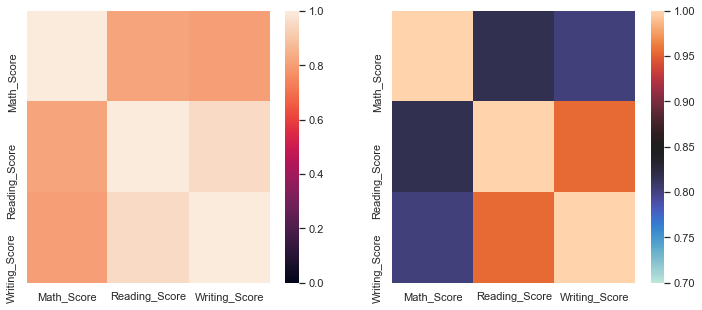

In [67]:
fig = plt.figure(figsize=(12,5))

plt.subplot(121)
sns.heatmap(data.corr(), vmin=0, vmax=1)

plt.subplot(122)
sns.heatmap(data.corr(), vmin=0.7, vmax=1, center=0.85)

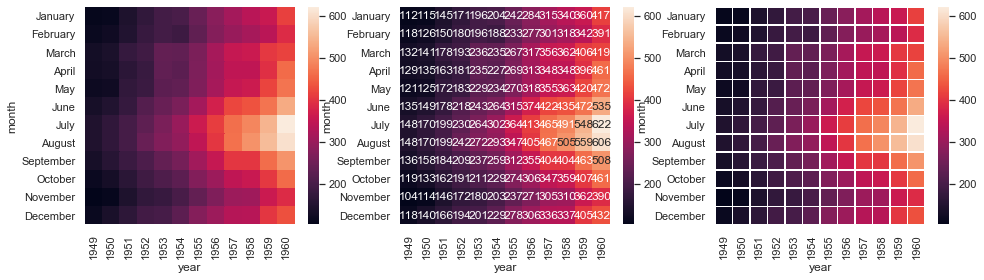

In [68]:
flights_mat = flights.pivot("month", "year", "passengers")

fig = plt.figure(figsize=(16,4))

plt.subplot(131)
sns.heatmap(flights_mat)

plt.subplot(132)
sns.heatmap(flights_mat, annot=True, fmt="d")

plt.subplot(133)
sns.heatmap(flights_mat, linewidths=.5) #add lines between each cell

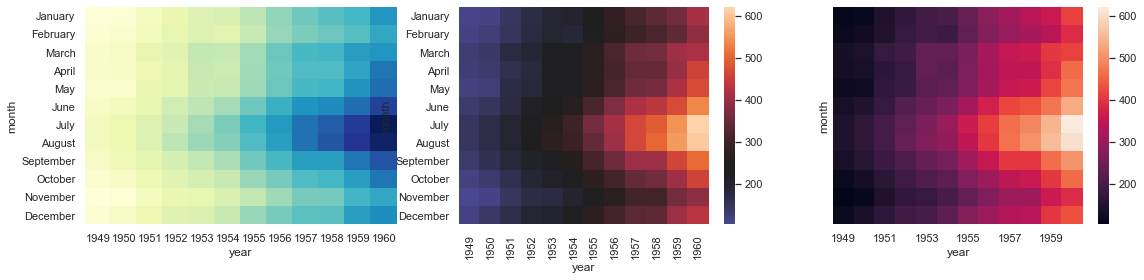

In [69]:
fig = plt.figure(figsize=(19,4))

plt.subplot(131) #Use a different color map, and don’t draw a colorbar:
sns.heatmap(flights_mat, cmap="YlGnBu", cbar=False)

plt.subplot(132)
sns.heatmap(flights_mat, center=flights_mat.loc["January", 1955]) #center the colormap at a specific value


plt.subplot(133)
#data = np.random.randn(50, 20)
sns.heatmap(flights_mat, xticklabels=2, yticklabels=False) #Plot every other column label and don’t plot row labels